In [ ]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyndamics3 import Simulation
from pyndamics3.fit import fit,Parameter

pyndamics3  version  0.0.31


In [ ]:
import lmfit

In [ ]:
t=array([7,14,21,28,35,42,49,56,63,70,77,84],float)
h=array([17.93,36.36,67.76,98.10,131,169.5,205.5,228.3,247.1,250.5,253.8,254.5])

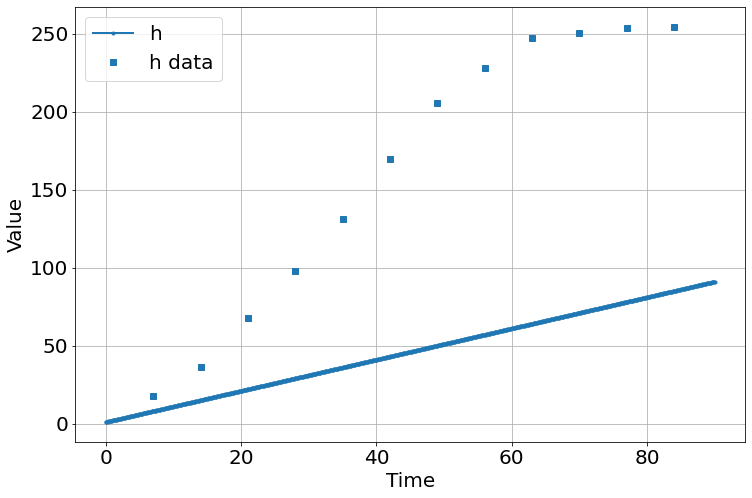

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("h'=a",1,plot=True)
sim.add_data(t=t,h=h,plot=True)
sim.params(a=1)
sim.run(0,90)

In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0),
   Parameter('initial_h',value=10,min=0))

results

In [ ]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyndamics3 import Struct

In [ ]:

# copied from http://be150.caltech.edu/2018/handouts/l12_stochastic_simulation.html

import numba

@numba.jit(nopython=True)
def _sample_discrete(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1


class Stochastic_Simulation(object):
    
    def __init__(self):
        self.components=[]
        self.equations=[]
        self.initial_values={}
        self.current_values={}
        self.ν=None
        self.state_change_strings=[]
        self.rate_equations=[]
        self.quasi=[]
        self._params={}
        self._params_keys=()
        self._params_vals=()
    
    def params(self,**kwargs):
        self._params.update(kwargs)
        self._params_keys=tuple(self._params.keys())
        self._params_vals=tuple([self._params[_] for _ in self._params_keys])
        
    def add(self,component_change_equation,rate_equation=None,plot=False,quasi=None,**kwargs):
        
        
        if "=" in component_change_equation:
            self.equations.append(component_change_equation)
            return 
        
        component_change_equation=component_change_equation.replace('+',' +')
        component_change_equation=component_change_equation.replace('-',' -')
        
        parts=component_change_equation.split()
        for part in parts:
            if not (part.startswith('-') or part.startswith('+')):
                raise SyntaxError("State change strings must start with + or -: %s" % component_change_equation)
            name=part[1:]
            if name not in self.components:
                self.components.append(name)
            
        self.state_change_strings.append(component_change_equation)            
        self.rate_equations.append(rate_equation)
        self.initial_values.update(kwargs)
        self.current_values.update(kwargs)
        self.quasi.append(quasi)

    def initialize(self):
        import numba
        import numpy as np
        num_components=len(self.components)
        num_reactions=len(self.rate_equations)
        self.ν=np.zeros((num_reactions,num_components),int)
        
        for j,(state_change,rate) in enumerate(zip(self.state_change_strings,self.rate_equations)):
            parts=state_change.split()
            for part in parts:
                if not (part.startswith('-') or part.startswith('+')):
                    raise SyntaxError("State change strings must start with + or -: %s" % component_change_equation)
                name=part[1:]
                if part[0]=='-':
                    val=-1
                else:
                    val=+1
                
                i=self.components.index(name)
                self.ν[j,i]=val
                    

        for c in self.initial_values:
            if not c in self.components:
                raise ValueError("%s not in components values." % c)
                    
        for c in self.components:
            if not c in self.initial_values:
                raise ValueError("%s not in initial values." % c)
            
            
        #func_str="@numba.jit(nopython=True)\ndef _propensity_function(population, args):\n"
        func_str="@numba.jit(nopython=True)\ndef _propensity_function_abcde(population, args):\n"

        func_str+="    "
        
        if len(self.components)>1:        
            func_str+=",".join(self.components) + " = population\n"
        else:
            func_str+=self.components[0] + ", = population\n"
                        
        if self._params_keys:
            func_str+="    "
            if len(self._params_keys)>1:        
                func_str+=",".join(self._params_keys)+ " = args\n"
            else:
                func_str+=self._params_keys[0]+ ", = args\n"
            
        func_str+="    "+"\n"

        for eq in self.equations:
            func_str+="    "+eq+"\n"


        func_str+="    "+"\n"


        func_str+="    "+"val = np.array([\n"
        for a in self.rate_equations:
            func_str+="        "+a+",\n"
        func_str+="    "+"],float)\n"

        for qi,q in enumerate(self.quasi):
            if not q:
                continue
                
            func_str+="    "+f"if ({q}):\n"
            func_str+="    "+"    "+f"val[{qi}]=0\n"
        
            func_str+="    "+f"if ((A==0) or (B==0)):\n"
            func_str+="    "+"    "+f"raise ValueError()\n"
                
        
        func_str+="    "+"return val"
        
        
        self.func_str=func_str
            
        exec (func_str,globals())                      
        self.propensity_function=_propensity_function_abcde
        
    def run(self,t_max,Nsims=1,num_iterations=1001,):
        from tqdm import tqdm
        
        
        if self.ν is None:
            self.initialize()

        _propensity_function=self.propensity_function
        
        
        @numba.jit(nopython=True)
        def _ssa(update, population_0, time_points, args):
            # Initialize output
            pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

            # Initialize and perform simulation
            i_time = 1
            i = 0
            t = time_points[0]
            population = population_0.copy()
            pop_out[0,:] = population
            extinction_time=-1.0
            previous_t=t
            while i < len(time_points):
                while t < time_points[i_time]:
                    # draw the event and time step
                    event, dt = _draw(population, args)

                    # Update the population
                    population_previous = population.copy()
                    population += update[event,:]

                    # Increment time
                    previous_t=t
                    t += dt


                if dt==1e500 and extinction_time<0.0:
                    extinction_time=previous_t

                # Update the index (Have to be careful about types for Numba)
                i = np.searchsorted((time_points > t).astype(np.int64), 1)

                # Update the population
                for j in np.arange(i_time, min(i, len(time_points))):
                    pop_out[j,:] = population_previous

                # Increment index
                i_time = i

            return pop_out,extinction_time
        
        @numba.jit(nopython=True)
        def _draw(population, args):
            """
            Draws a reaction and the time it took to do that reaction.

            Assumes that there is a globally scoped function
            `prop_func` that is Numba'd with nopython=True.
            """
            # Compute propensities
            props = _propensity_function(population, args)

            # Sum of propensities
            props_sum = np.sum(props)

            if props_sum==0:
                time=1e500
                rxn=0
            else:

                # Compute time
                time = np.random.exponential(1 / props_sum)

                # Draw reaction given propensities
                rxn = _sample_discrete(props, props_sum)

            return rxn, time

        
        self.all_storage=[]
        
        disable=Nsims==1
        
        population_0=np.array([self.initial_values[c] for c in self.components], dtype=int)
        time_points=np.linspace(0,t_max,num_iterations)        
        args = np.array(self._params_vals)
        n_simulations = Nsims

        # Initialize output array
        pops = np.empty((n_simulations, len(time_points), len(population_0)), dtype=int)
        extinction_time=np.empty(n_simulations,dtype=np.float64)

        # Run the calculations
        for _i in tqdm(range(n_simulations),disable=disable):
            pops[_i,:,:],extinction_time[_i] = _ssa(self.ν, 
                                        population_0, time_points, args=args)            

        self.t=time_points
        self.extinction_times=extinction_time
        D={}
        for _i,c in enumerate(self.components):
            v=pops[:,:,_i]
            if v.shape[0]==1:
                v=v.ravel()
                
            setattr(self, c,v)
            D[c]=v
        
        for eq in self.equations:
            exec(eq,D)
            name=eq.split('=')[0].strip()
            setattr(self, name,D[name])

  

In [ ]:
# β=0.2
# γ=0.1
# So=990
# Io=10

# stoch_sim=sim=Stochastic_Simulation()
# sim.add("+A",'A',A=1)
# sim.add("-A",'A**2/10')
# sim.run(10,Nsims=100)

# for i in range(100):    
#     plot(sim.t,sim.A[i],'b-o',alpha=0.05)

In [ ]:
# β=0.2
# γ=0.1
# So=990
# Io=10

# stoch_sim=sim=Stochastic_Simulation()
# sim.add("+A",'A',A=1)
# sim.add("-A",'A**2/10',quasi='A==1')
# sim.run(10,Nsims=100)

# for i in range(100):    
#     plot(sim.t,sim.A[i],'b-o',alpha=0.05)

In [ ]:
print(sim.func_str)

def _simfunc(_vec,t,_sim):
    initial_h=_sim.initial_value['h']

    a=_sim.original_params['a']

    h=_vec[0]


    _diff=[]
    _val=a
    _diff.append(_val)

    return _diff



In [ ]:
@numba.jit(nopython=True)
def _propensity_function_abcde(population, args):
    A, = population
    
    
    val = np.array([
        A,
        A**2/10,
    ],float)
    return val

## Is there a problem with X'=0?

In [ ]:
from pyndamics3 import Simulation

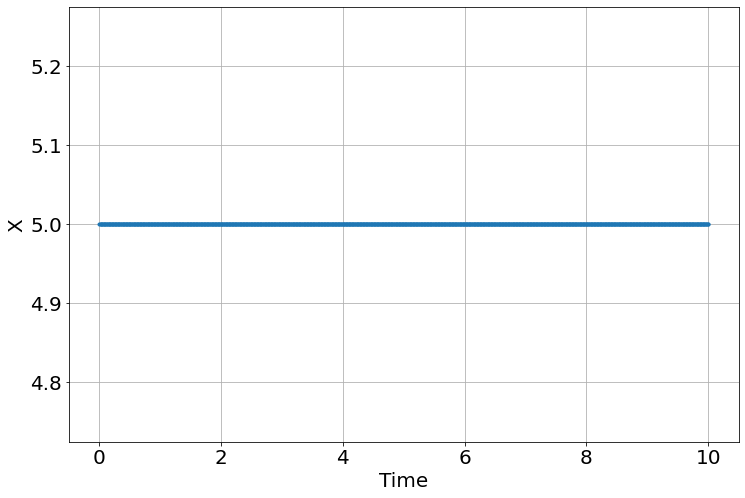

<Figure size 432x288 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("X'=0",5,plot=True)
sim.params(α=5)
sim.run(10)

In [ ]:
sim.original_params

{'α': 5}

In [ ]:
from pyndamics3.chem import ChemSimulation

In [ ]:
sim=ChemSimulation(
"""
D --k1--> D+M
M --k2--> M+P
M --k3--> ϕ
P --k4--> ϕ
""",D=1,M=0,ϕ=0,P=0,k1=.01,k3=0.00577,k4=0.0001925,k2=20*0.00577)

['D'] k1 ['D', 'M']
['M'] k2 ['M', 'P']
['M'] k3 ['ϕ']
['P'] k4 ['ϕ']
Components ['D', 'M', 'P', 'ϕ']
Parameters ['k1', 'k2', 'k3', 'k4']
diffeqs ["D' = 0", "M' =  +k1*D -k3*M", "P' =  +k2*M -k4*P"]


In [ ]:
sim.myparams

{'from_values': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'sin': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'cos': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'exp': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'tan': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'abs': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'floor': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'ceil': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'radians': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'degrees': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'sinh': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'cosh': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'tanh': <function pyndamics3.core.array_wrap.<locals>.what(*args, **kw)>,
 'arccos': <func

In [ ]:
sim.run(10)

In [ ]:
sim.equations()

"D'=0\nM'=+k1*D -k3*M\nP'=+k2*M -k4*P\nk1=0.01\nk2=0.1154\nk3=0.00577\nk4=0.0001925\n"

In [ ]:
print(sim.func_str)

def _simfunc(_vec,t,_sim):
    initial_D=_sim.initial_value['D']
    initial_M=_sim.initial_value['M']
    initial_P=_sim.initial_value['P']

    k1=_sim.original_params['k1']
    k2=_sim.original_params['k2']
    k3=_sim.original_params['k3']
    k4=_sim.original_params['k4']

    D=_vec[0]
    M=_vec[1]
    P=_vec[2]


    _diff=[]
    _val=0
    _diff.append(_val)
    _val=+k1*D -k3*M
    _diff.append(_val)
    _val=+k2*M -k4*P
    _diff.append(_val)

    return _diff



In [ ]:
print(sim.equations())

D'=0
M'=+k1*D -k3*M
P'=+k2*M -k4*P
k1=0.01
k2=0.1154
k3=0.00577
k4=0.0001925



In [ ]:
sim.params()